## Goal

Here we want to know the parameter range, including 

1. The distance between a pair of atoms
2. The maximum of Omega
3. The maximum of abs value of Delta
4. The slew rate of Omega, Delta, and phi

that the local simulator can give reasonable result. And we will investigate what to suggest to customers if they want to go out of the range. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time

from braket.ahs.hamiltonian import Hamiltonian
from braket.ahs.atom_arrangement import AtomArrangement
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField

from braket.devices import LocalSimulator
device = LocalSimulator("braket_ahs")

from pprint import pprint as pp

def get_counters_from_result(result):
    post_sequences = [list(measurement.post_sequence) for measurement in result.measurements]
    post_sequences = ["".join(['r' if site==0 else 'g' for site in post_sequence]) for post_sequence in post_sequences]

    counters = {}
    for post_sequence in post_sequences:
        if post_sequence in counters:
            counters[post_sequence] += 1
        else:
            counters[post_sequence] = 1
    return counters


In [2]:
num0 = 8 # number of data points for a_range
num1 = 8 # number of data points for Omega
num2 = 8 # number of data points for Delta
a_range = np.linspace(2.0, 8.0, num0) * 1e-6 # The range of atomic distance
Omega_range = np.linspace(1.0, 20.0, num1) * 1e6 # The range of Omega
Delta_range = np.linspace(0.0, 200.0, num2) * 1e6 # The range of Omega

t_max = 4e-6 # We fix the duration of the program
C6 = 5.42e-24 # The interaction coefficient
# shots = 10_000 # We fix the number of shots
shots = 100 # We fix the number of shots
steps = 100 # For time steps
nsteps = 1000 # For scipy
epsilon = 0.01 # threshold for the discrepancy of local sim and theory result

def Rb(Omega, Delta):
    return (C6/np.sqrt(Omega**2 + Delta**2))**(1/6)

In [3]:
def compare(programs, steps = steps, shots = shots, nsteps=nsteps):


    results_sim = {}
    results_theory = {}
    diff = {}

    total_time = 0
    for key, program in programs.items():
        
        start_time = time.time()        
        try:
            result = device.run(program, steps = steps, shots = shots, nsteps=nsteps).result()
        except:
            print(f"Error for {key}")
            continue
            
        total_time += time.time() - start_time            
        
        print(f"Result got for {key}")
        result_sim_temp = get_counters_from_result(result)
        
        results_sim[key] = {'gg': 0, 'rg': 0, 'gr': 0, 'rr': 0}
        
        
        num_pairs = int(len(list(result_sim_temp.keys())[0])/2)
                
        for key2, val2 in result_sim_temp.items():
            for i in range(num_pairs):
                results_sim[key][key2[2*i:2*i+2]] += val2

        # Get the theory result
        R, Omega, Delta = key[0]*1e-6, key[1]*1e6, key[2]*1e6
        H = np.array([
            [0, Omega/2, Omega/2, 0], 
            [Omega/2, -Delta, 0, Omega/2], 
            [Omega/2, 0, -Delta, Omega/2], 
            [0, Omega/2, Omega/2, -2*Delta + C6/(R**6)]
        ])

        U = scipy.linalg.expm(-1j * t_max * H)

        gg_theory = round(np.abs(U[0][0])**2 * shots*num_pairs)
        gr_theory = round(np.abs(U[0][1])**2 * shots*num_pairs)
        rg_theory = round(np.abs(U[0][2])**2 * shots*num_pairs)        
        rr_theory = shots*num_pairs - gg_theory - gr_theory - rg_theory
        

        results_theory[key] = {
            'gg': gg_theory,
            'gr': gr_theory,
            'rg': gr_theory,
            'rr': rr_theory        
        }

        diff[key] = {}

        
        for state in ['gg', 'gr', 'rg', 'rr']:
            diff[key][state] = abs(results_theory[key][state]-results_sim[key][state])/(shots*num_pairs)
            
    # average runtime per program
    avg_time = total_time/len(programs)            
    return results_sim, results_theory, diff, avg_time

def visualize_diff(diff, state="gg", a_range = a_range, Omega_range = Omega_range, Delta_range = Delta_range):
    data = {}
    num_digits = 2
    for a in a_range:
        a2 = np.round(a*1e6, num_digits)
        data[a2] = np.full((len(Omega_range), len(Delta_range)), None, dtype = float)

    for key, val in diff.items():
        a, Omega, Delta = key[0], key[1], key[2]
        a2 = np.round(a, num_digits)
        Omega_ind = np.absolute(Omega_range - Omega * 1e6).argmin()
        Delta_ind = np.absolute(Delta_range - Delta * 1e6).argmin()        
        data[a2][Omega_ind, Delta_ind] = val[state] * 100
        
#     return data

    cols = 4
    rows = int(np.ceil(len(a_range)/cols))
#     fig, axn = plt.subplots(rows, cols, sharex=True, sharey=True, figsize = (4*6*rows, 4), squeeze=False)
    fig, axn = plt.subplots(rows, cols, sharex=True, sharey=True, squeeze=False)
    #     print(axn[1,1])
    cbar_ax = fig.add_axes([0.9, 0.1, .03, 0.9])

    for ind_a, a in enumerate(a_range):
        row = int(np.floor(ind_a/4))
        col = ind_a - 4 * row
        a2 = np.round(a*1e6, num_digits)
        ax = axn[row, col]
        sns.heatmap(data[a2], 
                    ax=ax,
#                     vmin=0, vmax=1,
                    cbar_ax=cbar_ax)
        ax.set_title(f"a={a2} (micrometers)", fontsize = 20)
        ax.set_xticks([0+0.5, len(Delta_range)-1+0.5])
        ax.set_yticks([0+0.5, len(Omega_range)-1+0.5])        
        ax.set_xlabel('Delta (MHz)', fontsize = 20)
        ax.set_ylabel('Omega (MHz)', fontsize = 20)     
        
        xticklabels = np.round(Delta_range[[0, len(Delta_range)-1]]/1e6, 2)
        yticklabels = np.round(Omega_range[[0, len(Omega_range)-1]]/1e6, 2)        
        ax.set_xticklabels(xticklabels, fontsize = 20)
        ax.set_yticklabels(yticklabels, fontsize = 20)

       
    fig.tight_layout(rect=[0, 0, .9, 1]) 

## Task 2: Const program for 5 pairs of atoms
This is for testing the robustness of the scipy solver


## Conclusion

1. With default parameters, the solver failed for 4 micrometers and below, and for the successful runs, the error is around 0.2%

2. Increasing the number of `nsteps` help to run programs with closer atomic distance [double the default number of `nsteps` helps to run 3.71 micrometers]. The error rate is around 0.2%.

3. Increasing the number of `steps` help to run programs with closer atomic distance [double the default number of `nsteps` helps to run 3.71 micrometers]. But the error rate is around 0.5%.



In [4]:
programs = {}
for a in a_range:
    for Omega in Omega_range:
        for Delta in Delta_range:
            register = AtomArrangement()
            
            for row in range(5):
                register.add([0, row * 10 * a])
                register.add([a, row * 10 * a])
            
            Omega_global = TimeSeries()
            Omega_global.put(0.0, Omega)
            Omega_global.put(t_max, Omega)

            # e.g. all-zero phase and detuning
            phi = TimeSeries().put(0.0, 0.0).put(t_max, 0.0)  # (time [s], value [rad])
            Delta_global = TimeSeries().put(0.0, Delta).put(t_max, Delta)  # (time [s], value [rad/s])

            drive = DrivingField(
                amplitude=Omega_global,
                phase=phi,
                detuning=Delta_global
            )            
            
            program = AnalogHamiltonianSimulation(
                hamiltonian=drive,
                register=register
            )
            
            programs[(a/1e-6, Omega/1e6, Delta/1e6)] = program
            

In [5]:
# programs

In [6]:
results_sim, results_theory, diff, avg_time = compare(programs)

/home/maolinml/.local/lib/python3.7/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/atom_arrangement.py:109: UserWarning: Sites 0([Decimal('0'), Decimal('0.0')]) and site 1([Decimal('0.000002'), Decimal('0.0')]) are too close. Their Euclidean distance (0.000002 meters) is smaller than the typical scale (0.000004 meters). The coordinates of the sites should be specified in SI units.
  f"Sites {index_1}({site_1}) and site {index_2}({site_2}) are too close. "
/home/maolinml/.local/lib/python3.7/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/atom_arrangement.py:109: UserWarning: Sites 2([Decimal('0'), Decimal('0.000019999999999999998')]) and site 3([Decimal('0.000002'), Decimal('0.000019999999999999998')]) are too close. Their Euclidean distance (0.00000200000000000000 meters) is smaller than the typical scale (0.000004 meters). The coordinates of the sites should be specified in SI units.
  f"Sites {index_1}({site_1}) and site {index_2}({site_2})

Error for (2.0, 1.0, 0.0)
Error for (2.0, 1.0, 28.571428571428573)
Error for (2.0, 1.0, 57.142857142857146)
Error for (2.0, 1.0, 85.71428571428572)
Error for (2.0, 1.0, 114.28571428571429)


/home/maolinml/.local/lib/python3.7/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:23: UserWarning: Value 0 (142857142.85714287) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  f"Value {i} ({value}) in {name} time series outside the typical range "


Error for (2.0, 1.0, 142.85714285714286)


/home/maolinml/.local/lib/python3.7/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:23: UserWarning: Value 0 (171428571.42857143) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  f"Value {i} ({value}) in {name} time series outside the typical range "


Error for (2.0, 1.0, 171.42857142857144)


/home/maolinml/.local/lib/python3.7/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/field_validator_util.py:23: UserWarning: Value 0 (200000000.0) in detuning time series outside the typical range [-125000000.0, 125000000.0]. The values should  be specified in SI units.
  f"Value {i} ({value}) in {name} time series outside the typical range "


Error for (2.0, 1.0, 200.0)
Error for (2.0, 3.7142857142857144, 0.0)
Error for (2.0, 3.7142857142857144, 28.571428571428573)
Error for (2.0, 3.7142857142857144, 57.142857142857146)
Error for (2.0, 3.7142857142857144, 85.71428571428572)
Error for (2.0, 3.7142857142857144, 114.28571428571429)
Error for (2.0, 3.7142857142857144, 142.85714285714286)
Error for (2.0, 3.7142857142857144, 171.42857142857144)
Error for (2.0, 3.7142857142857144, 200.0)
Error for (2.0, 6.428571428571429, 0.0)
Error for (2.0, 6.428571428571429, 28.571428571428573)
Error for (2.0, 6.428571428571429, 57.142857142857146)
Error for (2.0, 6.428571428571429, 85.71428571428572)
Error for (2.0, 6.428571428571429, 114.28571428571429)
Error for (2.0, 6.428571428571429, 142.85714285714286)
Error for (2.0, 6.428571428571429, 171.42857142857144)
Error for (2.0, 6.428571428571429, 200.0)
Error for (2.0, 9.142857142857142, 0.0)
Error for (2.0, 9.142857142857142, 28.571428571428573)
Error for (2.0, 9.142857142857142, 57.142857142

/home/maolinml/.local/lib/python3.7/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/atom_arrangement.py:70: UserWarning: Arrangement is too tall. Sites [Decimal('0'), Decimal('0.0')] and [Decimal('0.0000028571428571428573'), Decimal('0.00011428571428571428')] have y-separation bigger than the typical scale (0.0001 meters). The coordinates of the atoms should be specified in SI units.
  f"Arrangement is too tall. Sites {sorted_sites[0]} and {sorted_sites[-1]} "
/home/maolinml/.local/lib/python3.7/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/atom_arrangement.py:109: UserWarning: Sites 0([Decimal('0'), Decimal('0.0')]) and site 1([Decimal('0.0000028571428571428573'), Decimal('0.0')]) are too close. Their Euclidean distance (0.000002857142857142857300000000000 meters) is smaller than the typical scale (0.000004 meters). The coordinates of the sites should be specified in SI units.
  f"Sites {index_1}({site_1}) and site {index_2}({site_2}) are to

Error for (2.857142857142857, 1.0, 0.0)
Error for (2.857142857142857, 1.0, 28.571428571428573)
Error for (2.857142857142857, 1.0, 57.142857142857146)
Error for (2.857142857142857, 1.0, 85.71428571428572)
Error for (2.857142857142857, 1.0, 114.28571428571429)
Error for (2.857142857142857, 1.0, 142.85714285714286)
Error for (2.857142857142857, 1.0, 171.42857142857144)
Error for (2.857142857142857, 1.0, 200.0)
Error for (2.857142857142857, 3.7142857142857144, 0.0)
Error for (2.857142857142857, 3.7142857142857144, 28.571428571428573)
Error for (2.857142857142857, 3.7142857142857144, 57.142857142857146)
Error for (2.857142857142857, 3.7142857142857144, 85.71428571428572)
Error for (2.857142857142857, 3.7142857142857144, 114.28571428571429)
Error for (2.857142857142857, 3.7142857142857144, 142.85714285714286)
Error for (2.857142857142857, 3.7142857142857144, 171.42857142857144)
Error for (2.857142857142857, 3.7142857142857144, 200.0)
Error for (2.857142857142857, 6.428571428571429, 0.0)
Erro

/home/maolinml/.local/lib/python3.7/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/atom_arrangement.py:70: UserWarning: Arrangement is too tall. Sites [Decimal('0'), Decimal('0.0')] and [Decimal('0.000003714285714285714'), Decimal('0.00014857142857142857')] have y-separation bigger than the typical scale (0.0001 meters). The coordinates of the atoms should be specified in SI units.
  f"Arrangement is too tall. Sites {sorted_sites[0]} and {sorted_sites[-1]} "
/home/maolinml/.local/lib/python3.7/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/atom_arrangement.py:109: UserWarning: Sites 0([Decimal('0'), Decimal('0.0')]) and site 1([Decimal('0.000003714285714285714'), Decimal('0.0')]) are too close. Their Euclidean distance (0.000003714285714285714000000000000 meters) is smaller than the typical scale (0.000004 meters). The coordinates of the sites should be specified in SI units.
  f"Sites {index_1}({site_1}) and site {index_2}({site_2}) are too 

Error for (3.7142857142857144, 1.0, 0.0)
Error for (3.7142857142857144, 1.0, 28.571428571428573)
Error for (3.7142857142857144, 1.0, 57.142857142857146)
Error for (3.7142857142857144, 1.0, 85.71428571428572)
Error for (3.7142857142857144, 1.0, 114.28571428571429)
Error for (3.7142857142857144, 1.0, 142.85714285714286)
Error for (3.7142857142857144, 1.0, 171.42857142857144)
Error for (3.7142857142857144, 1.0, 200.0)
Error for (3.7142857142857144, 3.7142857142857144, 0.0)
Error for (3.7142857142857144, 3.7142857142857144, 28.571428571428573)
Error for (3.7142857142857144, 3.7142857142857144, 57.142857142857146)
Error for (3.7142857142857144, 3.7142857142857144, 85.71428571428572)
Error for (3.7142857142857144, 3.7142857142857144, 114.28571428571429)
Error for (3.7142857142857144, 3.7142857142857144, 142.85714285714286)
Error for (3.7142857142857144, 3.7142857142857144, 171.42857142857144)
Error for (3.7142857142857144, 3.7142857142857144, 200.0)
Error for (3.7142857142857144, 6.428571428

/home/maolinml/.local/lib/python3.7/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/atom_arrangement.py:70: UserWarning: Arrangement is too tall. Sites [Decimal('0'), Decimal('0.0')] and [Decimal('0.000004571428571428571'), Decimal('0.00018285714285714284')] have y-separation bigger than the typical scale (0.0001 meters). The coordinates of the atoms should be specified in SI units.
  f"Arrangement is too tall. Sites {sorted_sites[0]} and {sorted_sites[-1]} "


Result got for (4.571428571428571, 1.0, 0.0)
Result got for (4.571428571428571, 1.0, 28.571428571428573)
Result got for (4.571428571428571, 1.0, 57.142857142857146)
Result got for (4.571428571428571, 1.0, 85.71428571428572)
Result got for (4.571428571428571, 1.0, 114.28571428571429)
Result got for (4.571428571428571, 1.0, 142.85714285714286)
Result got for (4.571428571428571, 1.0, 171.42857142857144)
Result got for (4.571428571428571, 1.0, 200.0)
Result got for (4.571428571428571, 3.7142857142857144, 0.0)
Result got for (4.571428571428571, 3.7142857142857144, 28.571428571428573)
Result got for (4.571428571428571, 3.7142857142857144, 57.142857142857146)
Result got for (4.571428571428571, 3.7142857142857144, 85.71428571428572)
Result got for (4.571428571428571, 3.7142857142857144, 114.28571428571429)
Result got for (4.571428571428571, 3.7142857142857144, 142.85714285714286)
Result got for (4.571428571428571, 3.7142857142857144, 171.42857142857144)
Result got for (4.571428571428571, 3.714

/home/maolinml/.local/lib/python3.7/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/atom_arrangement.py:70: UserWarning: Arrangement is too tall. Sites [Decimal('0'), Decimal('0.0')] and [Decimal('0.000005428571428571429'), Decimal('0.00021714285714285715')] have y-separation bigger than the typical scale (0.0001 meters). The coordinates of the atoms should be specified in SI units.
  f"Arrangement is too tall. Sites {sorted_sites[0]} and {sorted_sites[-1]} "


Result got for (5.428571428571429, 1.0, 0.0)
Result got for (5.428571428571429, 1.0, 28.571428571428573)
Result got for (5.428571428571429, 1.0, 57.142857142857146)
Result got for (5.428571428571429, 1.0, 85.71428571428572)
Result got for (5.428571428571429, 1.0, 114.28571428571429)
Result got for (5.428571428571429, 1.0, 142.85714285714286)
Result got for (5.428571428571429, 1.0, 171.42857142857144)
Result got for (5.428571428571429, 1.0, 200.0)
Result got for (5.428571428571429, 3.7142857142857144, 0.0)
Result got for (5.428571428571429, 3.7142857142857144, 28.571428571428573)
Result got for (5.428571428571429, 3.7142857142857144, 57.142857142857146)
Result got for (5.428571428571429, 3.7142857142857144, 85.71428571428572)
Result got for (5.428571428571429, 3.7142857142857144, 114.28571428571429)
Result got for (5.428571428571429, 3.7142857142857144, 142.85714285714286)
Result got for (5.428571428571429, 3.7142857142857144, 171.42857142857144)
Result got for (5.428571428571429, 3.714

/home/maolinml/.local/lib/python3.7/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/atom_arrangement.py:70: UserWarning: Arrangement is too tall. Sites [Decimal('0'), Decimal('0.0')] and [Decimal('0.000006285714285714285'), Decimal('0.0002514285714285714')] have y-separation bigger than the typical scale (0.0001 meters). The coordinates of the atoms should be specified in SI units.
  f"Arrangement is too tall. Sites {sorted_sites[0]} and {sorted_sites[-1]} "


Result got for (6.285714285714286, 1.0, 0.0)
Result got for (6.285714285714286, 1.0, 28.571428571428573)
Result got for (6.285714285714286, 1.0, 57.142857142857146)
Result got for (6.285714285714286, 1.0, 85.71428571428572)
Result got for (6.285714285714286, 1.0, 114.28571428571429)
Result got for (6.285714285714286, 1.0, 142.85714285714286)
Result got for (6.285714285714286, 1.0, 171.42857142857144)
Result got for (6.285714285714286, 1.0, 200.0)
Result got for (6.285714285714286, 3.7142857142857144, 0.0)
Result got for (6.285714285714286, 3.7142857142857144, 28.571428571428573)
Result got for (6.285714285714286, 3.7142857142857144, 57.142857142857146)
Result got for (6.285714285714286, 3.7142857142857144, 85.71428571428572)
Result got for (6.285714285714286, 3.7142857142857144, 114.28571428571429)
Result got for (6.285714285714286, 3.7142857142857144, 142.85714285714286)
Result got for (6.285714285714286, 3.7142857142857144, 171.42857142857144)
Result got for (6.285714285714286, 3.714

/home/maolinml/.local/lib/python3.7/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/atom_arrangement.py:70: UserWarning: Arrangement is too tall. Sites [Decimal('0'), Decimal('0.0')] and [Decimal('0.000007142857142857142'), Decimal('0.0002857142857142857')] have y-separation bigger than the typical scale (0.0001 meters). The coordinates of the atoms should be specified in SI units.
  f"Arrangement is too tall. Sites {sorted_sites[0]} and {sorted_sites[-1]} "


Result got for (7.142857142857142, 1.0, 0.0)
Result got for (7.142857142857142, 1.0, 28.571428571428573)
Result got for (7.142857142857142, 1.0, 57.142857142857146)
Result got for (7.142857142857142, 1.0, 85.71428571428572)
Result got for (7.142857142857142, 1.0, 114.28571428571429)
Result got for (7.142857142857142, 1.0, 142.85714285714286)
Result got for (7.142857142857142, 1.0, 171.42857142857144)
Result got for (7.142857142857142, 1.0, 200.0)
Result got for (7.142857142857142, 3.7142857142857144, 0.0)
Result got for (7.142857142857142, 3.7142857142857144, 28.571428571428573)
Result got for (7.142857142857142, 3.7142857142857144, 57.142857142857146)
Result got for (7.142857142857142, 3.7142857142857144, 85.71428571428572)
Result got for (7.142857142857142, 3.7142857142857144, 114.28571428571429)
Result got for (7.142857142857142, 3.7142857142857144, 142.85714285714286)
Result got for (7.142857142857142, 3.7142857142857144, 171.42857142857144)
Result got for (7.142857142857142, 3.714

/home/maolinml/.local/lib/python3.7/site-packages/braket/analog_hamiltonian_simulator/rydberg/validators/atom_arrangement.py:70: UserWarning: Arrangement is too tall. Sites [Decimal('0'), Decimal('0.0')] and [Decimal('0.000008'), Decimal('0.00031999999999999997')] have y-separation bigger than the typical scale (0.0001 meters). The coordinates of the atoms should be specified in SI units.
  f"Arrangement is too tall. Sites {sorted_sites[0]} and {sorted_sites[-1]} "


Result got for (8.0, 1.0, 0.0)
Result got for (8.0, 1.0, 28.571428571428573)
Result got for (8.0, 1.0, 57.142857142857146)
Result got for (8.0, 1.0, 85.71428571428572)
Result got for (8.0, 1.0, 114.28571428571429)
Result got for (8.0, 1.0, 142.85714285714286)
Result got for (8.0, 1.0, 171.42857142857144)
Result got for (8.0, 1.0, 200.0)
Result got for (8.0, 3.7142857142857144, 0.0)
Result got for (8.0, 3.7142857142857144, 28.571428571428573)
Result got for (8.0, 3.7142857142857144, 57.142857142857146)
Result got for (8.0, 3.7142857142857144, 85.71428571428572)
Result got for (8.0, 3.7142857142857144, 114.28571428571429)
Result got for (8.0, 3.7142857142857144, 142.85714285714286)
Result got for (8.0, 3.7142857142857144, 171.42857142857144)
Result got for (8.0, 3.7142857142857144, 200.0)
Result got for (8.0, 6.428571428571429, 0.0)
Result got for (8.0, 6.428571428571429, 28.571428571428573)
Result got for (8.0, 6.428571428571429, 57.142857142857146)
Result got for (8.0, 6.42857142857142

In [7]:
print(f"The average runtime per program = {avg_time} seconds")

The average runtime per program = 17.965502500068396 seconds


In [8]:
# results_sim

In [9]:
# results_theory

In [10]:
diff

{(4.571428571428571, 1.0, 0.0): {'gg': 0.012,
  'gr': 0.012,
  'rg': 0.002,
  'rr': 0.002},
 (4.571428571428571, 1.0, 28.571428571428573): {'gg': 0.0,
  'gr': 0.0,
  'rg': 0.0,
  'rr': 0.0},
 (4.571428571428571, 1.0, 57.142857142857146): {'gg': 0.0,
  'gr': 0.0,
  'rg': 0.0,
  'rr': 0.0},
 (4.571428571428571, 1.0, 85.71428571428572): {'gg': 0.0,
  'gr': 0.0,
  'rg': 0.0,
  'rr': 0.0},
 (4.571428571428571, 1.0, 114.28571428571429): {'gg': 0.0,
  'gr': 0.0,
  'rg': 0.0,
  'rr': 0.0},
 (4.571428571428571, 1.0, 142.85714285714286): {'gg': 0.0,
  'gr': 0.0,
  'rg': 0.0,
  'rr': 0.0},
 (4.571428571428571, 1.0, 171.42857142857144): {'gg': 0.0,
  'gr': 0.0,
  'rg': 0.0,
  'rr': 0.0},
 (4.571428571428571, 1.0, 200.0): {'gg': 0.0, 'gr': 0.0, 'rg': 0.0, 'rr': 0.0},
 (4.571428571428571, 3.7142857142857144, 0.0): {'gg': 0.028,
  'gr': 0.026,
  'rg': 0.004,
  'rr': 0.002},
 (4.571428571428571, 3.7142857142857144, 28.571428571428573): {'gg': 0.002,
  'gr': 0.004,
  'rg': 0.002,
  'rr': 0.0},
 (4.5714

In [11]:
for key, val in diff.items():
    if val['gg'] > epsilon:
        print(key, ", ", f"val['gg'] = {val['gg']}", ", ", f"Rb = {Rb(key[1] * 1e6, key[2] * 1e6) * 1e6}")

(4.571428571428571, 1.0, 0.0) ,  val['gg'] = 0.012 ,  Rb = 13.253580321870484
(4.571428571428571, 3.7142857142857144, 0.0) ,  val['gg'] = 0.028 ,  Rb = 10.65010762148655
(4.571428571428571, 9.142857142857142, 0.0) ,  val['gg'] = 0.03 ,  Rb = 9.165430996338408
(4.571428571428571, 9.142857142857142, 57.142857142857146) ,  val['gg'] = 0.016 ,  Rb = 6.738936873821222
(4.571428571428571, 11.857142857142858, 0.0) ,  val['gg'] = 0.012 ,  Rb = 8.776806810137794
(4.571428571428571, 14.571428571428573, 0.0) ,  val['gg'] = 0.022 ,  Rb = 8.480397170615142
(4.571428571428571, 14.571428571428573, 28.571428571428573) ,  val['gg'] = 0.018 ,  Rb = 7.435510721498998
(4.571428571428571, 17.285714285714285, 28.571428571428573) ,  val['gg'] = 0.016 ,  Rb = 7.3856660693104015
(4.571428571428571, 17.285714285714285, 114.28571428571429) ,  val['gg'] = 0.012 ,  Rb = 6.0050406869161055
(4.571428571428571, 20.0, 28.571428571428573) ,  val['gg'] = 0.014 ,  Rb = 7.3323924143501475
(4.571428571428571, 20.0, 57.1428

/home/maolinml/.local/lib/python3.7/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/home/maolinml/.local/lib/python3.7/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
/home/maolinml/.local/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


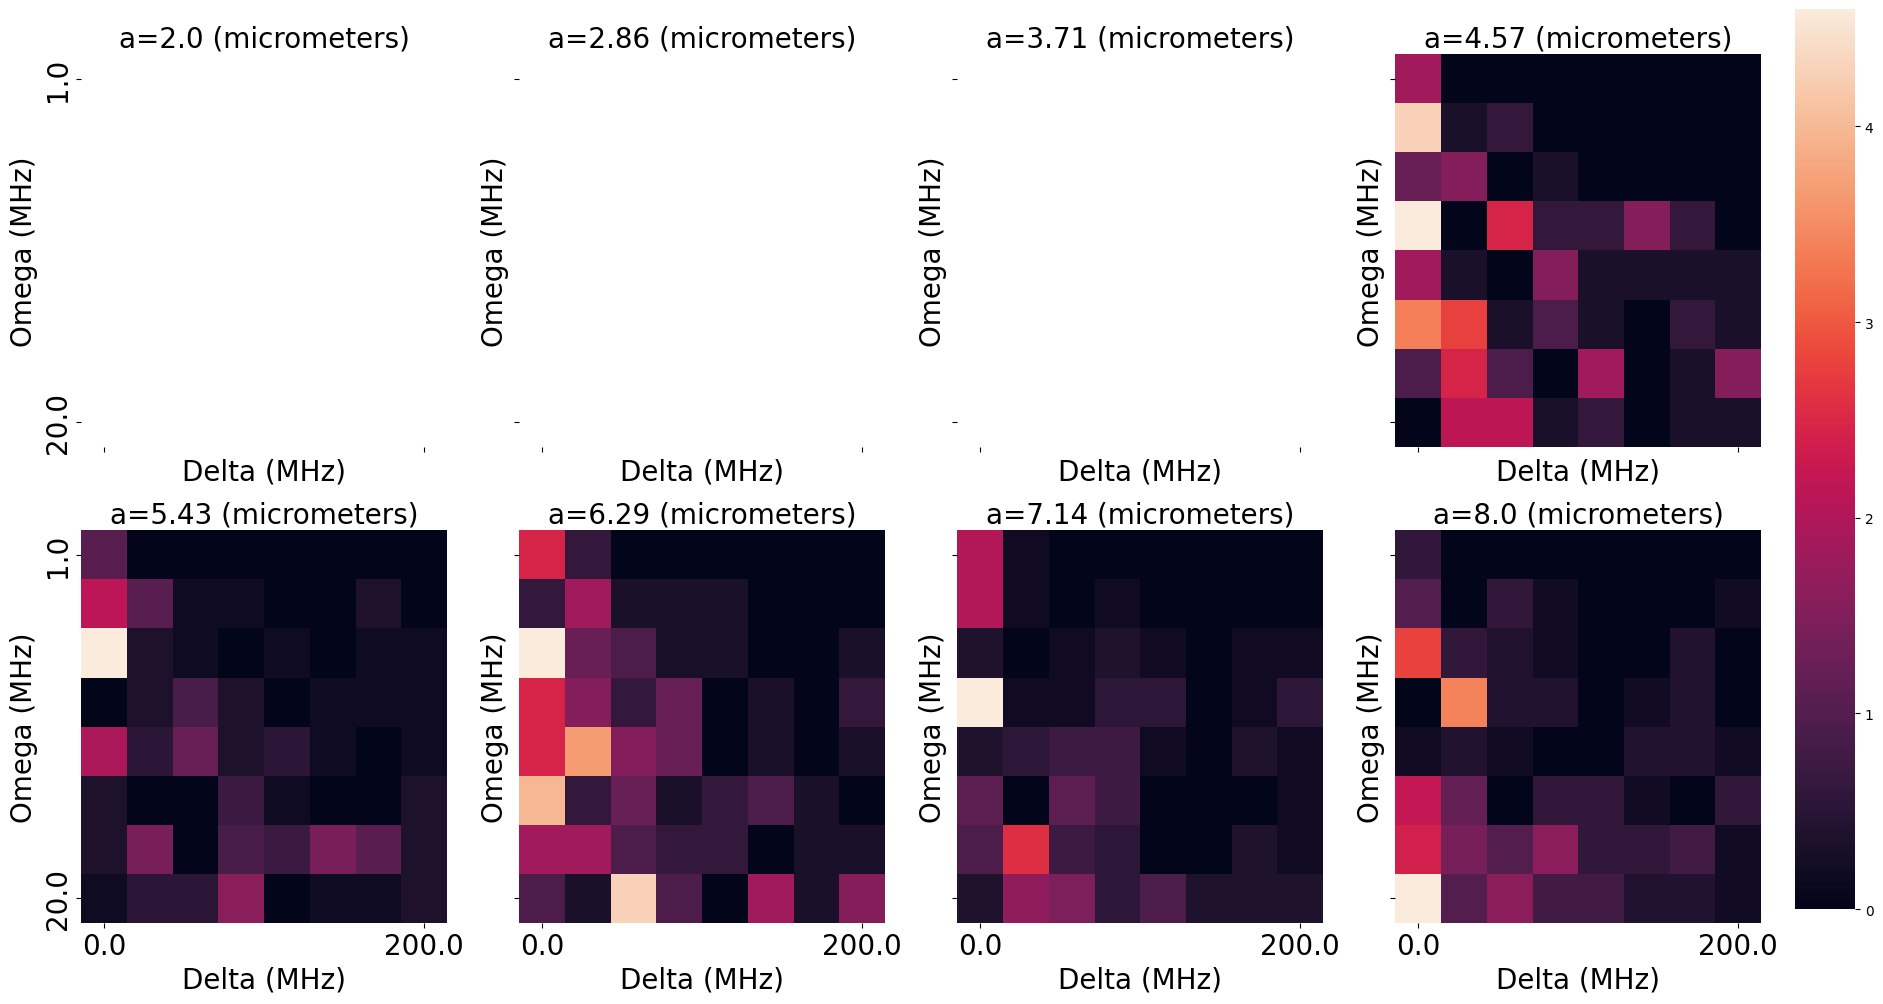

In [12]:
plt.rcParams["figure.figsize"] = (20,10)
visualize_diff(diff)

## Rerun with larger nsteps

In [13]:
results_sim, results_theory, diff, avg_time = compare(programs, nsteps = 2000)

Error for (2.0, 1.0, 0.0)
Error for (2.0, 1.0, 28.571428571428573)
Error for (2.0, 1.0, 57.142857142857146)
Error for (2.0, 1.0, 85.71428571428572)
Error for (2.0, 1.0, 114.28571428571429)
Error for (2.0, 1.0, 142.85714285714286)
Error for (2.0, 1.0, 171.42857142857144)
Error for (2.0, 1.0, 200.0)
Error for (2.0, 3.7142857142857144, 0.0)
Error for (2.0, 3.7142857142857144, 28.571428571428573)
Error for (2.0, 3.7142857142857144, 57.142857142857146)
Error for (2.0, 3.7142857142857144, 85.71428571428572)
Error for (2.0, 3.7142857142857144, 114.28571428571429)
Error for (2.0, 3.7142857142857144, 142.85714285714286)
Error for (2.0, 3.7142857142857144, 171.42857142857144)
Error for (2.0, 3.7142857142857144, 200.0)
Error for (2.0, 6.428571428571429, 0.0)
Error for (2.0, 6.428571428571429, 28.571428571428573)
Error for (2.0, 6.428571428571429, 57.142857142857146)
Error for (2.0, 6.428571428571429, 85.71428571428572)
Error for (2.0, 6.428571428571429, 114.28571428571429)
Error for (2.0, 6.42857

In [14]:
print(f"The average runtime per program = {avg_time} seconds")

The average runtime per program = 50.26639503054321 seconds


/home/maolinml/.local/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


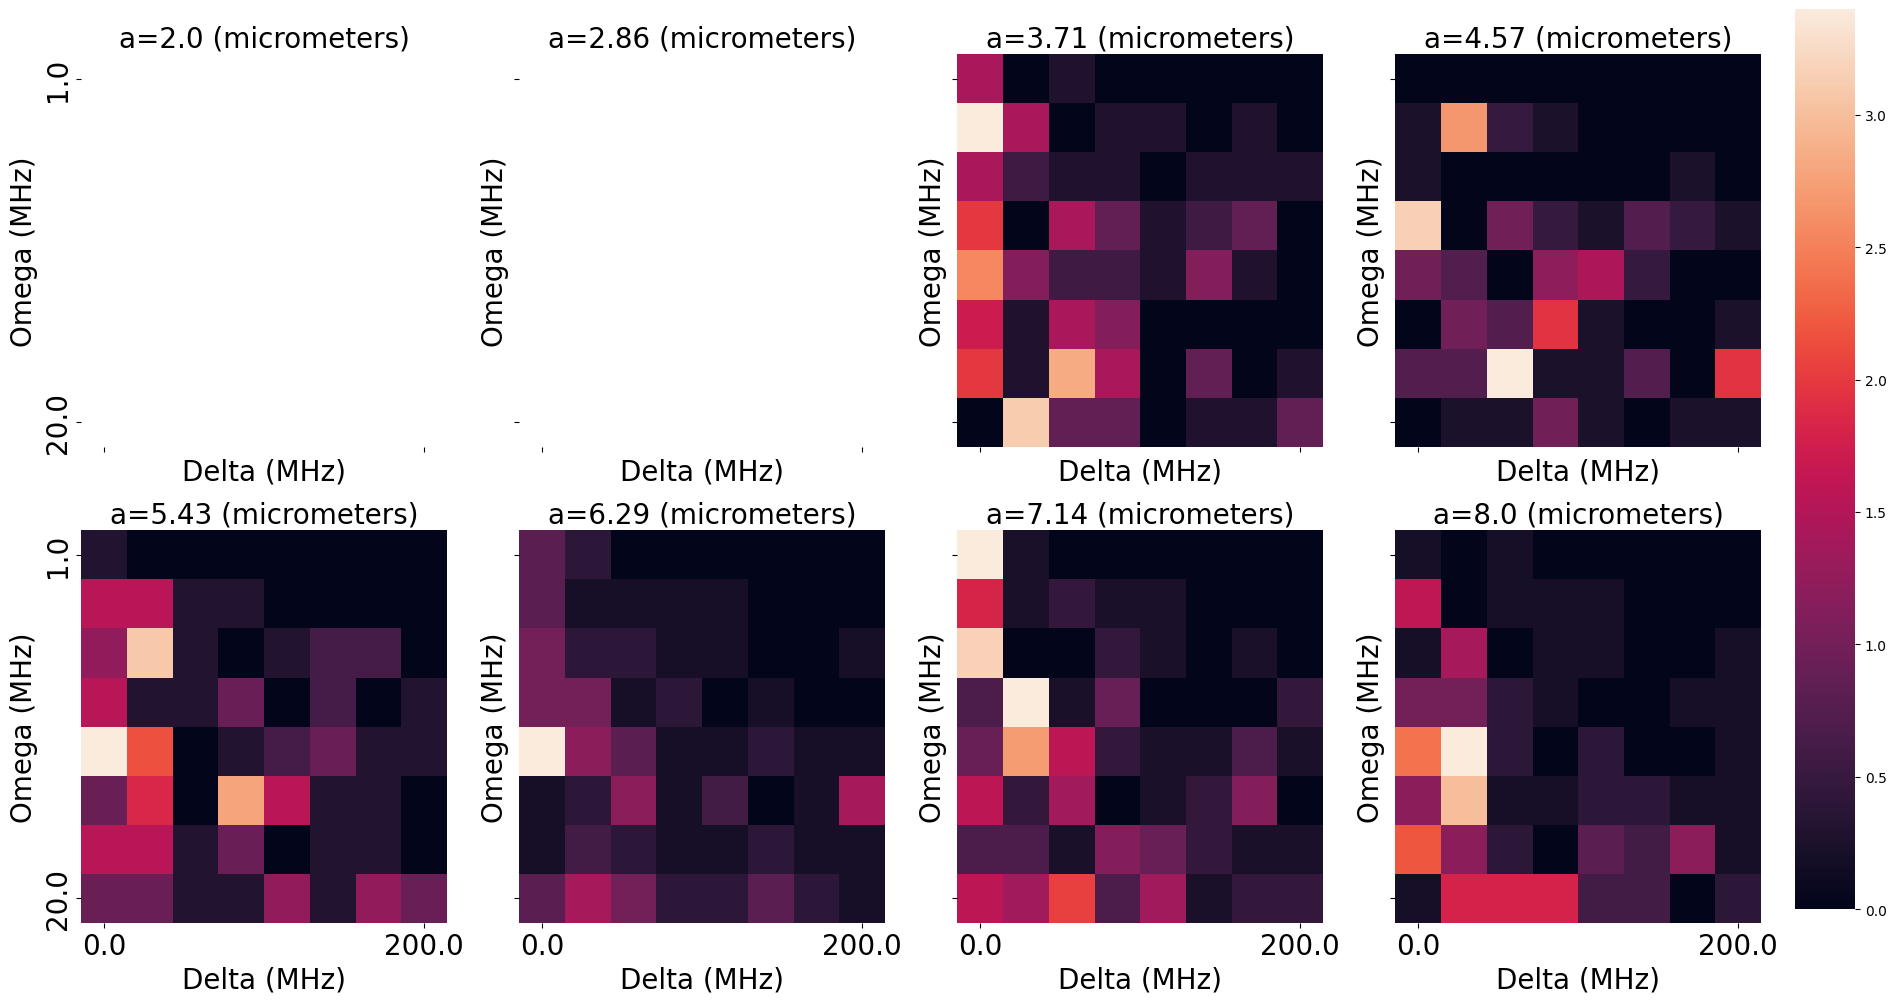

In [15]:
plt.rcParams["figure.figsize"] = (20,10)
visualize_diff(diff)

## Rerun with larger number of time steps

In [16]:
results_sim, results_theory, diff, avg_time = compare(programs, steps = 2 * steps)

Error for (2.0, 1.0, 0.0)
Error for (2.0, 1.0, 28.571428571428573)
Error for (2.0, 1.0, 57.142857142857146)
Error for (2.0, 1.0, 85.71428571428572)
Error for (2.0, 1.0, 114.28571428571429)
Error for (2.0, 1.0, 142.85714285714286)
Error for (2.0, 1.0, 171.42857142857144)
Error for (2.0, 1.0, 200.0)
Error for (2.0, 3.7142857142857144, 0.0)
Error for (2.0, 3.7142857142857144, 28.571428571428573)
Error for (2.0, 3.7142857142857144, 57.142857142857146)
Error for (2.0, 3.7142857142857144, 85.71428571428572)
Error for (2.0, 3.7142857142857144, 114.28571428571429)
Error for (2.0, 3.7142857142857144, 142.85714285714286)
Error for (2.0, 3.7142857142857144, 171.42857142857144)
Error for (2.0, 3.7142857142857144, 200.0)
Error for (2.0, 6.428571428571429, 0.0)
Error for (2.0, 6.428571428571429, 28.571428571428573)
Error for (2.0, 6.428571428571429, 57.142857142857146)
Error for (2.0, 6.428571428571429, 85.71428571428572)
Error for (2.0, 6.428571428571429, 114.28571428571429)
Error for (2.0, 6.42857

In [17]:
print(f"The average runtime per program = {avg_time} seconds")

The average runtime per program = 51.812877162359655 seconds


/home/maolinml/.local/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


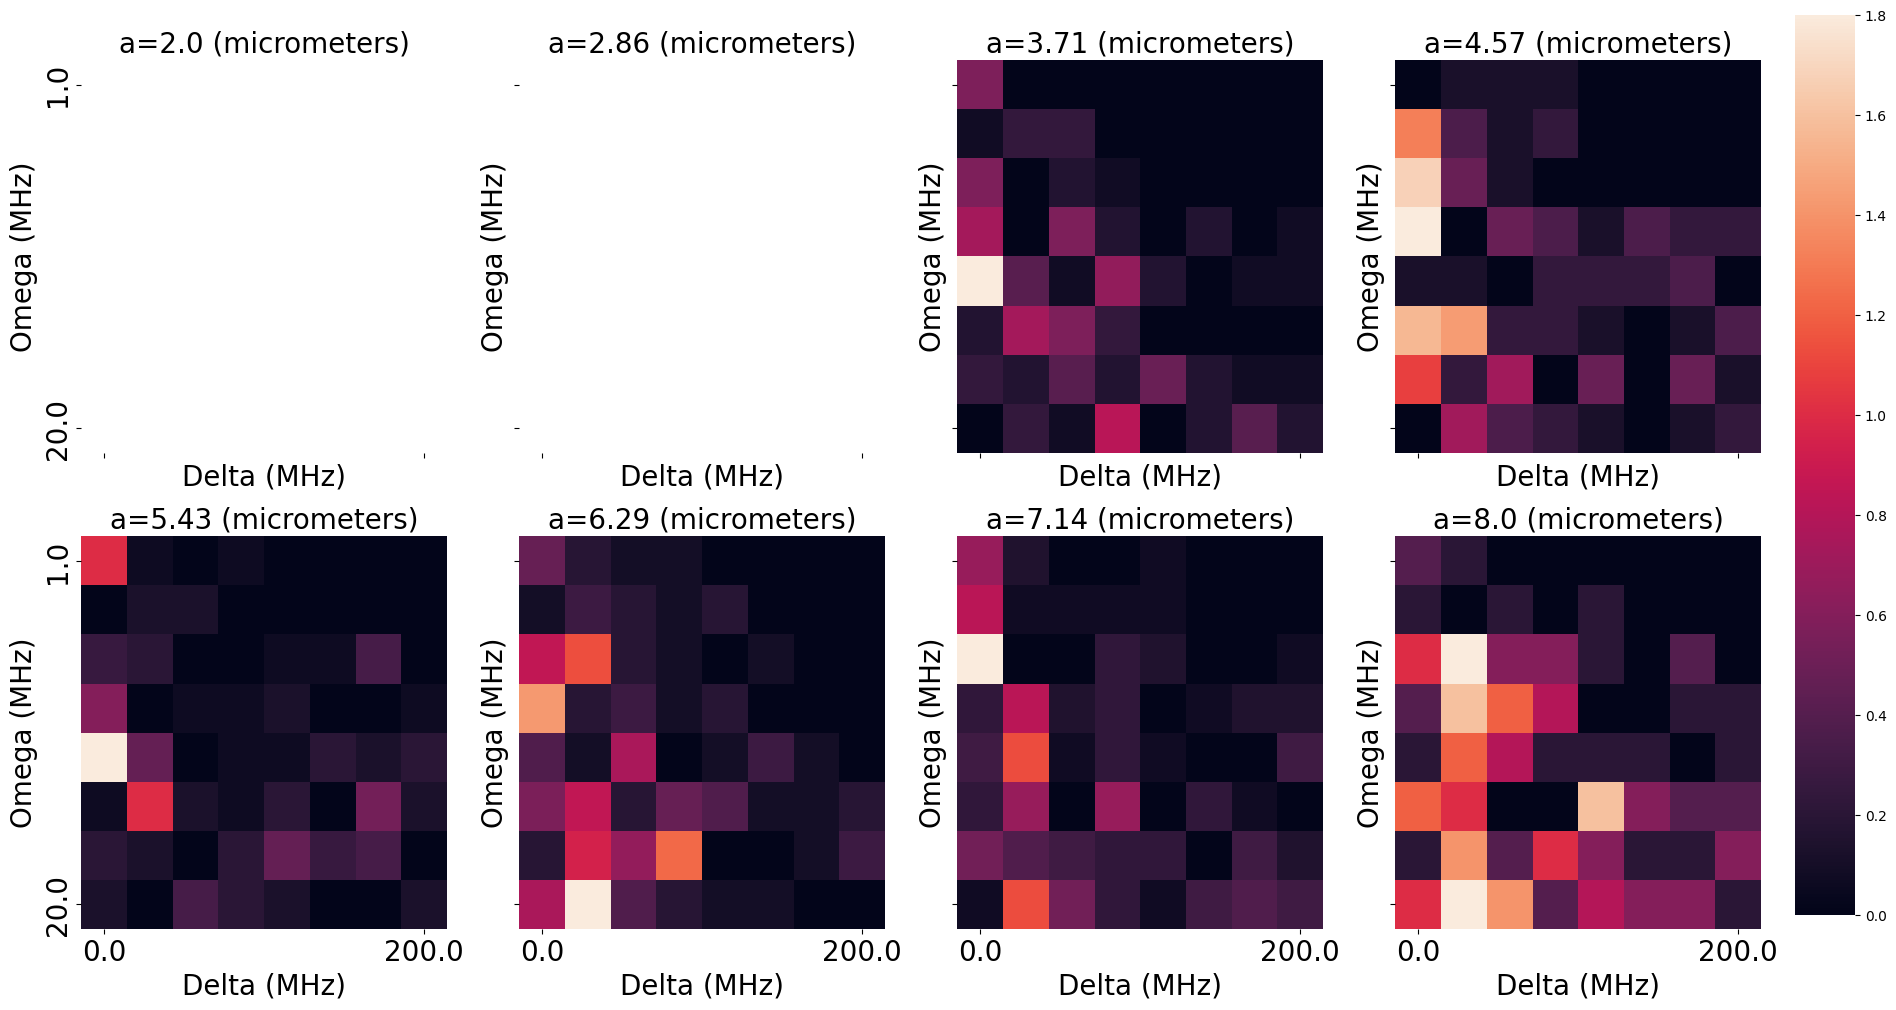

In [18]:
plt.rcParams["figure.figsize"] = (20,10)
visualize_diff(diff)